In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import funcy as fc
import pandas as pd
import re
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'

In [3]:
data = pd.DataFrame()
data['地区'] = ['江苏', '新疆', '广东', '河南', '安徽', '山东', 
              '湖北', '四川', '陕西', '河北', '浙江', '福建', 
              '湖南', '重庆', '江西', '辽宁', '甘肃', '云南', 
              '山西', '贵州', '黑龙江', '广西', '内蒙古', '上海', 
              '吉林', '天津', '北京', '宁夏', '青海', '海南', '西藏']

data['深夜学习活跃指数'] = [100, 88.8, 76.3, 74.4, 71.8, 69.3, 68.8, 
                   61.3, 55.5, 42.6, 41.3, 39.6, 37.1, 37.1, 36.2,
                   34.8, 33.5, 32.9, 31.6, 28.7, 26.8, 20.0, 17.6,
                   16.1, 13.9, 10.7, 10.6, 9.9, 7.4, 6.7, 1.0]

# 这里技巧性地利用地区作为临时索引，以方便对应之后的三种文字旋转排布方式
data.set_index('地区', inplace=True)
data.loc[:'湖南', '文字排布'] = 1
data.loc['重庆':'贵州', '文字排布'] = 2
data.loc['黑龙江':, '文字排布'] = 3
data.reset_index(drop=False, inplace=True)

data.head()

,地区,深夜学习活跃指数,文字排布
0,江苏,100.0,1.0
1,新疆,88.8,1.0
2,广东,76.3,1.0
3,河南,74.4,1.0
4,安徽,71.8,1.0


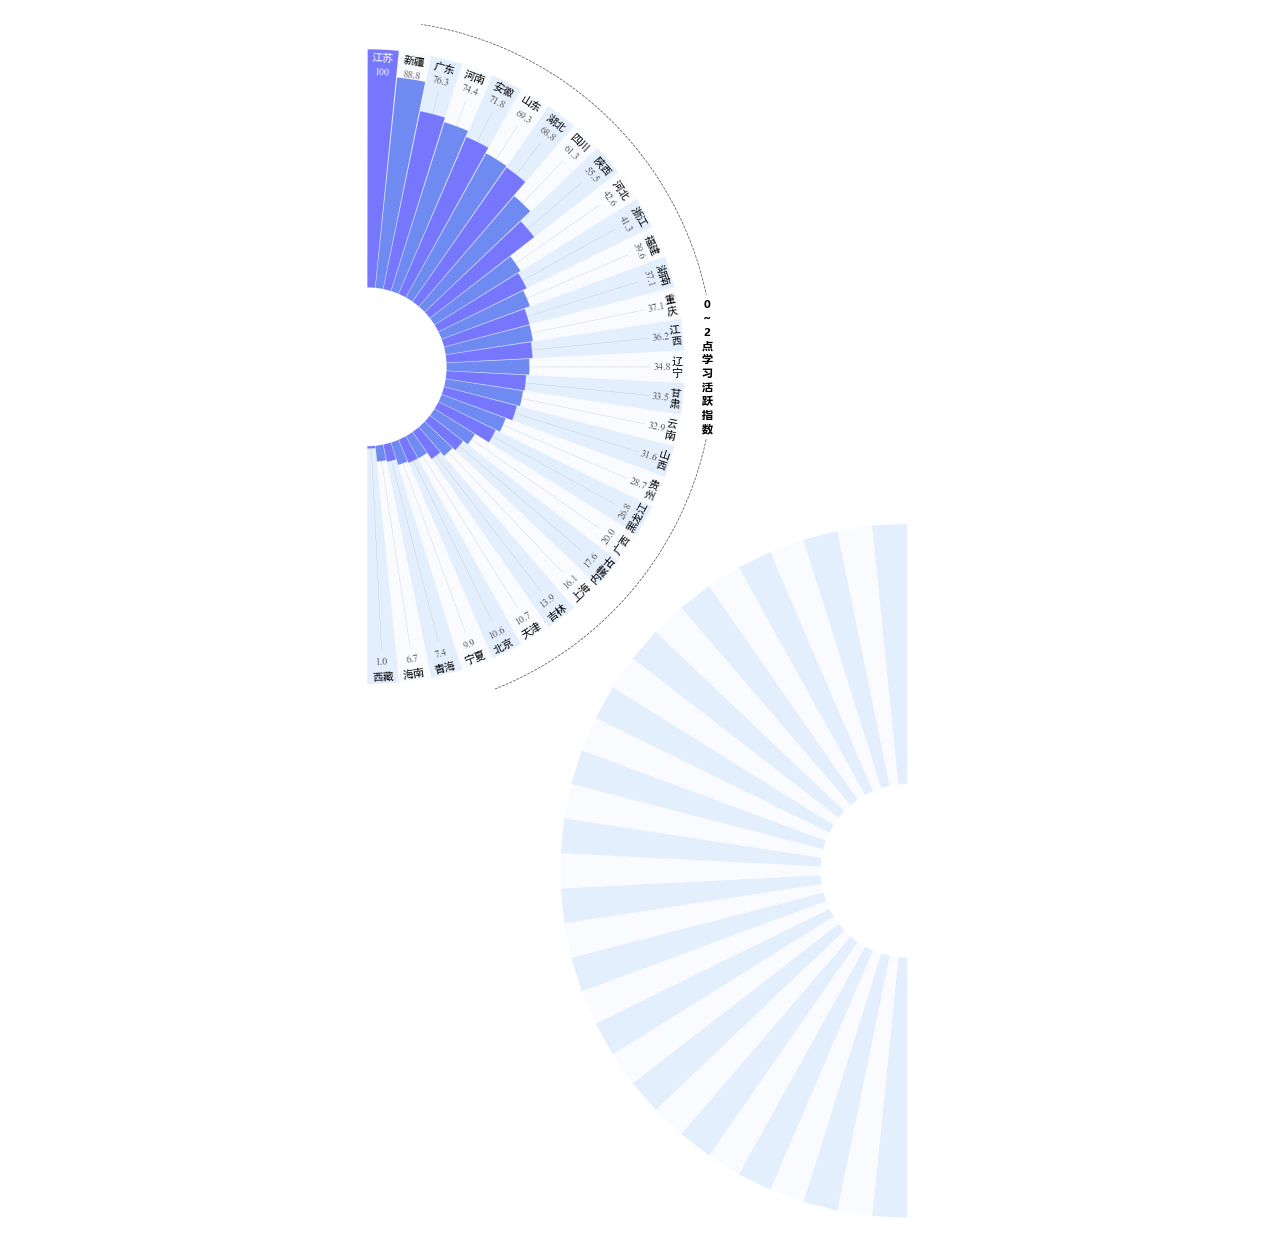

In [4]:
# 生成每份子扇形区域的两边夹角
# 这里[::-1]是为了迎合matplotlib极坐标默认的角度位置
theta_group = (np.linspace(-0.5, 0.5, 32)*np.pi)[::-1]

# 创建图床和原始axes对象
fig, ax = plt.subplots(figsize=(10, 10))

############################
# 主体部分
############################

# 向原始图床中插入极坐标系新axes对象
ax1 = fig.add_axes([-0.5, 0, 1, 1], polar=True)

# 绘制右半边扇形区域最底层错落的色带填充
for idx, group in enumerate(fc.pairwise(theta_group)):
    
    # 当下标为偶数时，填充#e3effd色
    if idx % 2 == 0:
        ax1.fill_between(group, 0.75, 3, facecolor='#e3effd')
    # 当下标为奇数时，填充#fafbff色
    else:
        ax1.fill_between(group, 0.75, 3, facecolor='#fafbff')

# 绘制每份子扇形区域的中央虚线
for idx, group in enumerate(fc.pairwise(theta_group)):
    theta = (group[0] + group[1]) / 2
    ax1.plot([theta, theta], [0.75, 2.68], linestyle='--', color='#9fa0a0',  linewidth=0.25)

# 绘制极坐标柱状图，分别占据每份子扇形区域的对应外扩长度
for idx, group in enumerate(fc.pairwise(theta_group)):
    theta = (group[0] + group[1]) / 2

    ax1.bar([theta], [2.25*data.at[idx, '深夜学习活跃指数']*0.01], 
            width=[np.pi / 32], bottom=0.75, 
            # 对下标分别为偶数与奇数的扇形绘制不同颜色
            facecolor='#6785f2' if idx % 2 != 0 else '#7171fe', 
            edgecolor='white', linewidth=0.1, alpha=0.95, zorder=9)

# 绘制子扇形区域之间交界处的白色边界
for theta in theta_group:
    ax1.plot([theta, theta], [1, 3], color='white',  linewidth=0.2)
    
def rotate_text(text, group, method):
    
    if method == 1:
        return text, ((group[0] + group[1]) * 0.5 / np.pi) * 180 - 90
    
    elif method == 2:
        return '\n'.join(list(text)), ((group[0] + group[1]) * 0.5 / np.pi) * 180
    
    elif method == 3:
        return text, ((group[0] + group[1]) * 0.5 / np.pi) * 180 - 90 + 180
    

# 地区+数值文字标注
for idx, group in enumerate(fc.pairwise(theta_group[::-1])):
    # 控制向data表的索引不越界
    if idx < 31:
        
        # 控制第一名的特殊字体颜色
        if data.at[30-idx, '地区'] == '江苏':
            text_color, value_color = 'white', 'white'
        else:
            text_color, value_color = 'black', '#595757'
        
        # 利用前面定义的自编函数生成对应的文字与旋转角度
        text, angle = rotate_text(data.at[30-idx, '地区'], group, method=data.at[30-idx, '文字排布'])
        
        # 标注地区名称
        ax1.annotate(text, xy=[(group[0]+group[1]) / 2, 2.925], 
                     va='center', ha='center', zorder=10,
                     color=text_color,
                     rotation=angle,
                     fontsize=11)
        
        # 标注深夜学习活跃指数
        ax1.annotate(re.sub('\.$', '', str(data.at[30-idx, '深夜学习活跃指数'])[:4]), 
                     xy=[(group[0]+group[1]) / 2, 2.79], 
                     va='center', ha='center', zorder=10,
                     rotation=angle,
                     fontsize=10,
                     color=value_color,
                     fontproperties='Times New Roman')

# 绘制外围黑色虚线
ax1.plot(np.linspace(-0.38, 0.45, 1000)*np.pi, [3.275]*1000, 
         linestyle='dashed', color='#595655', linewidth=0.75)

# 添加“0~2点学习活跃指数”标注
ax1.annotate('\n'.join(list('0~2点学习活跃指数')), 
             xy=[0, 3.21], 
             va='center', 
             ha='center', 
             ma='center',
             zorder=10,
             rotation=0,
             fontsize=11,
             color='black',
             fontproperties='Microsoft Yahei',
             fontweight='bold',
             bbox=dict(boxstyle="round", fc="white", ec="white", alpha=1))

############################
# 右下角点缀
############################

# 向原始图床中插入极坐标系新axes对象
ax2 = fig.add_axes([0.25, -0.7, 1, 1], polar=True)

theta_group2 = (np.linspace(-1.5, -0.5, 32)*np.pi)[::-1]

# 绘制左半边扇形区域最底层错落的色带填充
for idx, group in enumerate(fc.pairwise(theta_group2)):
    
    # 当下标为偶数时，填充#e3effd色
    if idx % 2 == 0:
        ax2.fill_between(group, 0.75, 3, facecolor='#e3effd')
    # 当下标为奇数时，填充#fafbff色
    else:
        ax2.fill_between(group, 0.75, 3, facecolor='#fafbff')

# 紧凑布局
fig.tight_layout(pad=0)

# 关闭所有axes的坐标轴线

ax.axis('off')
ax1.axis('off')
ax2.axis('off')

# 导出为图片
fig.savefig('图4.png', dpi=500, bbox_inches='tight', pad_inches=0, facecolor='white')